# General Description

This notebook uses R code, please make sure an R kernel is installed for your jupyter notebook or copy the code and run it in an R environment.

This notebook describes the steps for:
* downloading the data
* filtering of cells (cell types that are represented by less than 5 cells are filtered out)
* filtering of cell types (cell types that are present only in one condition, but not in the other are filtered out)
* merge datasets for joint normalisation 
* normalising data with scran
* splitting data after normalisation
* filtering lowly expressed genes (genes with mean expression less than 1 in all expressing cells are filtered out)
* filtering unshared genes (genes that are present only in one condition, but not in the other are filtered out)
* generate UMAP of the data

The **output** of this notebook  are two folders:
* AML328_d0_forComparative
* AML328_d29_forComparative

each of them containing following files:
* counts_filtered_norm.txt a normalised (NOT log2 transformed) filtered count matrix (gene names in rows, cell IDs in columns)
* anno_filtered.txt an annotation matrix (containing columns "Cell" and "cell_type").

# Donwload the data
For this analysis, we will use the sinlge cell RNAseq data from [van Galen et al, 2019](http://www.cell.com/cell/retrieve/pii/S0092867419300947?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867419300947%3Fshowall%3Dtrue). We will analyse the bone marrow of an acute myeloid leukemia (AML) patien at diagnosis (AML328-D0) and compare it to the bone marrow sample of the same patient after treatment (AML328-D29). Please download the following raw data at [GEO (GSE116256)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE116256). Please make sure that you have the following files in your working directory:
1. GSM3587931_AML328-D0.dem.txt
2. GSM3587932_AML328-D0.anno.txt
3. GSM3587937_AML328-D29.dem.txt
4. GSM3587938_AML328-D29.anno.txt

# Normalize and filter

## Merge datasets & filter cell types (x2)

In [1]:
options(stringsAsFactors = F)

In [2]:
# libraries
require(scran)
require(ggplot2)
require(dplyr)
require(Seurat)
require(umap)

Loading required package: scran

Loading required package: BiocParallel

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colMeans, colSums, colnames,
    dirname, do.call, duplicated, eval, evalq, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, mapply, match, mget,
    o

In [3]:
# Define paths
input.path <- getwd()
print(input.path)
output.path <- paste0(input.path
                      ,"/AML328_d0_d29_merged"
                      )
print(output.path)

[1] "/Users/MariaSolovey/Documents/Helmholtz/AG_Scialdone/our_papers/communication/DATASETS/AML_Bernstein_GSE116256/Tutorial_AML_PublicationFigs_revision"
[1] "/Users/MariaSolovey/Documents/Helmholtz/AG_Scialdone/our_papers/communication/DATASETS/AML_Bernstein_GSE116256/Tutorial_AML_PublicationFigs_revision/AML328_d0_d29_merged"


In [4]:
# Define pathien IDs
patientID1 <- "AML328_d0"
patientID2 <- "AML328_d29"

In [5]:
# read in raw counts
counts1 <- read.csv(paste0(input.path
                           ,"/GSM3587931_AML328-D0.dem.txt"
                           )
                    ,sep = "\t"
                    ,check.names = F
                    ,row.names = 1
                    )
dim(counts1)
counts2 <- read.csv(paste0(input.path
                           ,"/GSM3587937_AML328-D29.dem.txt"
                           )
                    ,sep = "\t"
                    ,check.names = F
                    ,row.names = 1
)
dim(counts2)

[1] 27899  1094

[1] 27899  1880

In [6]:
# read in annotations
anno1 <- read.csv(paste0(input.path
                         ,"/GSM3587932_AML328-D0.anno.txt")
                  ,sep = "\t"
                  ,check.names = F
)
dim(anno1)
anno2 <- read.csv(paste0(input.path
                         ,"/GSM3587938_AML328-D29.anno.txt")
                  ,sep = "\t"
                  ,check.names = F
)
dim(anno2)

[1] 1094   29

[1] 1880   29

In [7]:
# check correctness
if(!identical(anno1$Cell
              ,colnames(counts1))) stop("ERROR: cell IDs are not identical between annotation and counts in coundition 1!")
if(!identical(anno2$Cell
              ,colnames(counts2))) stop("ERROR: cell IDs are not identical between annotation and counts in coundition 2!")


In [8]:
# check that both count files have same genes, filter if necessary
if(!identical(rownames(counts1)
              ,rownames(counts2)
              )
){
        mutualGenes <- intersect(rownames(counts1)
                                 ,rownames(counts2)
        )
        counts1 <- counts1[rownames(counts1) %in% mutualGenes,]
        dim(counts1)
        counts2 <- counts2[rownames(counts2) %in% mutualGenes,]
        dim(counts2)
}


In [9]:
# check that bot annotation files have same column names, filter in necessary
if(!identical(colnames(anno1)
              ,colnames(anno2)
              )
){
        mutualColumns <- intersect(colnames(anno1)
                                   ,colnames(anno2)
        )
        anno1 <- anno1[,colnames(anno1) %in% mutualColumns]
        dim(anno1)
        anno2 <- anno2[,colnames(anno2) %in% mutualColumns]
        dim(anno2)
}

In [10]:
# add $patientID
anno1$patientID <- patientID1
anno2$patientID <- patientID2

FILTER CELL TYPES 1: note that we will filter out cell types that have less than 5 cells. (The threshold for filtering the cells was chosen arbitrarily!)

In [11]:
# filter for cells
minNrCells <- 5

cellNr1 <- table(anno1$CellType)
cellNr1
cellFilter1 <- names(cellNr1[cellNr1 >= minNrCells])
cellFilter1
idx_cell_filter1 <- anno1$CellType %in% cellFilter1
anno1_filtered <- anno1[idx_cell_filter1,]
counts1_cell_filtered <- counts1[,idx_cell_filter1]
dim(anno1_filtered)
dim(counts1_cell_filtered)

cellNr2 <- table(anno2$CellType)
cellNr2
cellFilter2 <- names(cellNr2[cellNr2 >= minNrCells])
cellFilter2
idx_cell_filter2 <- anno2$CellType %in% cellFilter2
anno2_filtered <- anno2[idx_cell_filter2,]
counts2_cell_filtered <- counts2[,idx_cell_filter2]
dim(anno2_filtered)
dim(counts2_cell_filtered)



           B          CTL     GMP-like          HSC     HSC-like         Mono 
          12           22            2           19          143           79 
   Mono-like           NK       Plasma         ProB      ProMono ProMono-like 
         214           75            7            1            3            1 
        Prog    Prog-like            T          cDC     cDC-like     earlyEry 
           8          281          108           12           52           44 
     lateEry          pDC 
           9            2 

[1] "B"         "CTL"       "HSC"       "HSC-like"  "Mono"      "Mono-like"
 [7] "NK"        "Plasma"    "Prog"      "Prog-like" "T"         "cDC"      
[13] "cDC-like"  "earlyEry"  "lateEry"

[1] 1085   30

[1] 27899  1085


           B          CTL          GMP     GMP-like          HSC     HSC-like 
          15           34            3           25           63          365 
        Mono    Mono-like           NK       Plasma         ProB ProMono-like 
           6           19          134            5            7            2 
        Prog    Prog-like            T     cDC-like     earlyEry      lateEry 
          16          721          282           13           82           76 
         pDC 
          12 

[1] "B"         "CTL"       "GMP-like"  "HSC"       "HSC-like"  "Mono"     
 [7] "Mono-like" "NK"        "Plasma"    "ProB"      "Prog"      "Prog-like"
[13] "T"         "cDC-like"  "earlyEry"  "lateEry"   "pDC"

[1] 1875   30

[1] 27899  1875

FILTER CELL TYPES 2: note that for the comparative analysis, we will filter out cell populations that are not present in one of the conditions!

In [12]:
# filter for shared populations
sharedPopulations <- intersect(cellFilter1
                               ,cellFilter2)
sharedPopulations

idx_sharedPopulations1 <- anno1$CellType %in% sharedPopulations
anno1_filtered <- anno1[idx_sharedPopulations1,]
counts1_cell_filtered <- counts1[,idx_sharedPopulations1]
dim(anno1_filtered)
dim(counts1_cell_filtered)

idx_sharedPopulations2 <- anno2$CellType %in% sharedPopulations
anno2_filtered <- anno2[idx_sharedPopulations2,]
counts2_cell_filtered <- counts2[,idx_sharedPopulations2]
dim(anno2_filtered)
dim(counts2_cell_filtered)

[1] "B"         "CTL"       "HSC"       "HSC-like"  "Mono"      "Mono-like"
 [7] "NK"        "Plasma"    "Prog"      "Prog-like" "T"         "cDC-like" 
[13] "earlyEry"  "lateEry"

[1] 1073   30

[1] 27899  1073

[1] 1831   30

[1] 27899  1831

In [13]:
# concatenate
anno_merged <- rbind(anno1_filtered
                     ,anno2_filtered)
dim(anno_merged)

counts_merged <- cbind(counts1_cell_filtered
                       ,counts2_cell_filtered)
dim(counts_merged)

[1] 2904   30

[1] 27899  2904

In [14]:
# add column $cell_type (needed for CellPhoneDB)
anno_merged$cell_type <- anno_merged$CellType

In [15]:
# export
dir.create(output.path)
write.table(counts_merged
            ,file = paste0(output.path
                           ,"/counts_merged.txt")
            ,sep = "\t")
write.table(anno_merged
            ,file = paste0(output.path
                           ,"/anno_merged.txt")
            ,sep = "\t")

Warning message in dir.create(output.path):
“'/Users/MariaSolovey/Documents/Helmholtz/AG_Scialdone/our_papers/communication/DATASETS/AML_Bernstein_GSE116256/Tutorial_AML_PublicationFigs_revision/AML328_d0_d29_merged' existiert bereits”


## Normalize data

In [16]:
options(stringsAsFactors = F)

In [17]:
# Define paths
input.path <- output.path
print(input.path)

[1] "/Users/MariaSolovey/Documents/Helmholtz/AG_Scialdone/our_papers/communication/DATASETS/AML_Bernstein_GSE116256/Tutorial_AML_PublicationFigs_revision/AML328_d0_d29_merged"


In [18]:
# read in data
anno <- read.csv(file = paste0(input.path
                               ,"/anno_merged.txt")
                 ,check.names = F
                 ,sep = "\t")
dim(anno)
colnames(anno)
rownames(anno) <- anno$Cell
counts <- read.csv(file = paste0(input.path
                                 ,"/counts_merged.txt")
                   ,check.names = F
                   ,row.names = 1
                   ,sep = "\t")
dim(counts)

[1] 2904   31

[1] "Cell"                   "NumberOfReads"          "AlignedToGenome"       
 [4] "AlignedToTranscriptome" "TranscriptomeUMIs"      "NumberOfGenes"         
 [7] "CyclingScore"           "CyclingBinary"          "MutTranscripts"        
[10] "WtTranscripts"          "PredictionRF2"          "PredictionRefined"     
[13] "CellType"               "Score_HSC"              "Score_Prog"            
[16] "Score_GMP"              "Score_ProMono"          "Score_Mono"            
[19] "Score_cDC"              "Score_pDC"              "Score_earlyEry"        
[22] "Score_lateEry"          "Score_ProB"             "Score_B"               
[25] "Score_Plasma"           "Score_T"                "Score_CTL"             
[28] "Score_NK"               "NanoporeTranscripts"    "patientID"             
[31] "cell_type"

[1] 27899  2904

In [19]:
# check cell ID correction
if(!identical(anno$Cell
              ,colnames(counts))) stop("ERROR: cell IDs are not identical in the annotatin and the count table!")


In [20]:
# delete all-zero genes
idx_allZero <- rowSums(counts) == 0
counts_filter <- counts[!idx_allZero,]
dim(counts_filter)

[1] 19685  2904

In [21]:
# check correctness
if(!identical(anno$Cell
              ,colnames(counts_filter))) stop("ERROR: cell IDs are not identical in the annotation and the counts after filtering!")



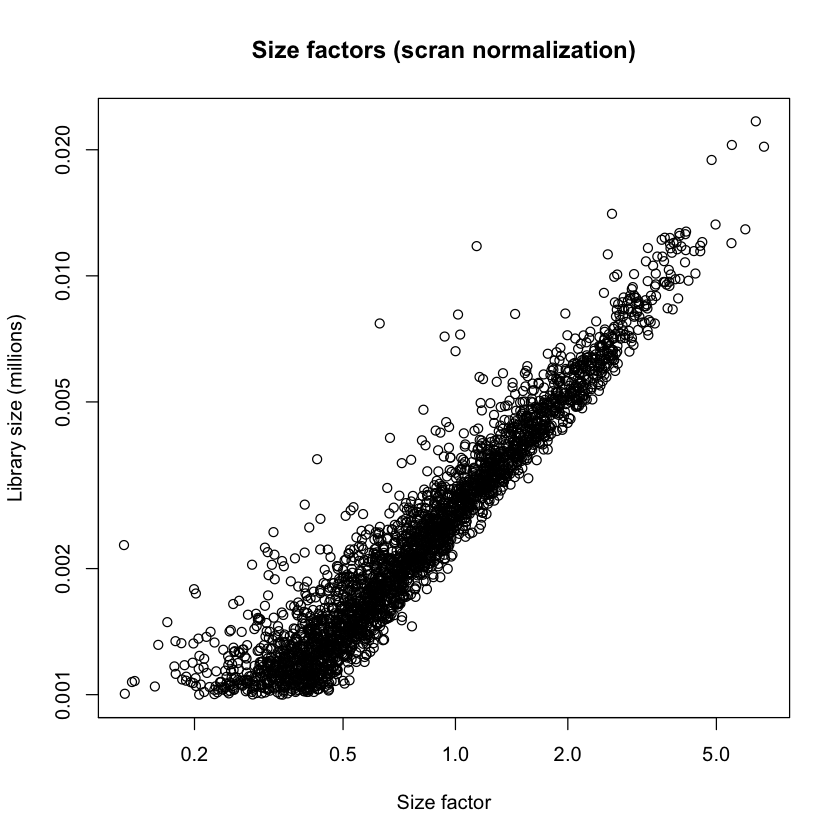

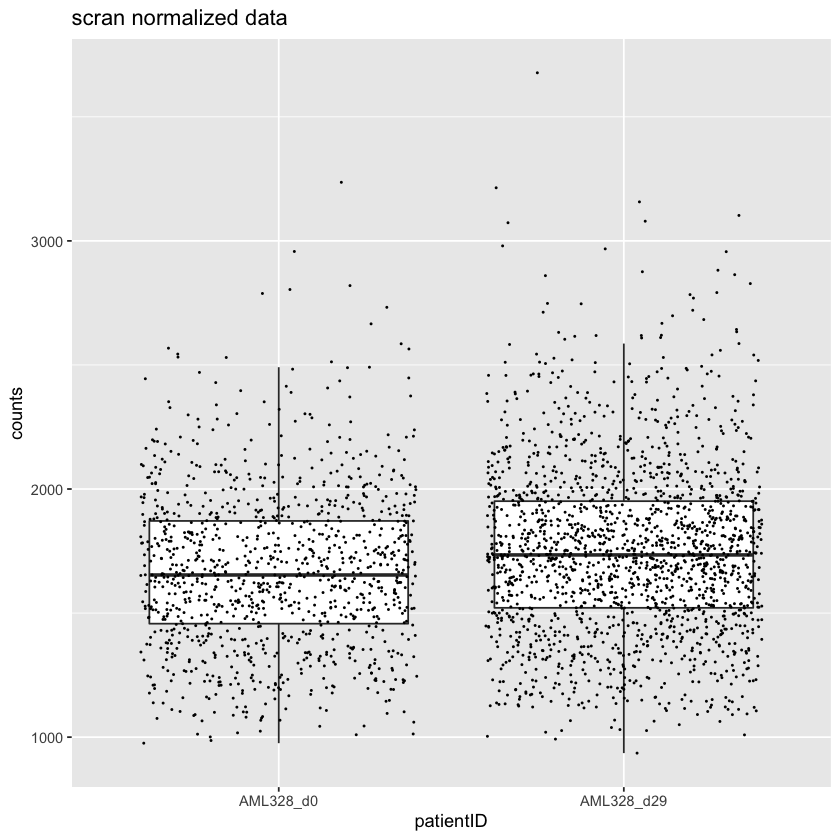

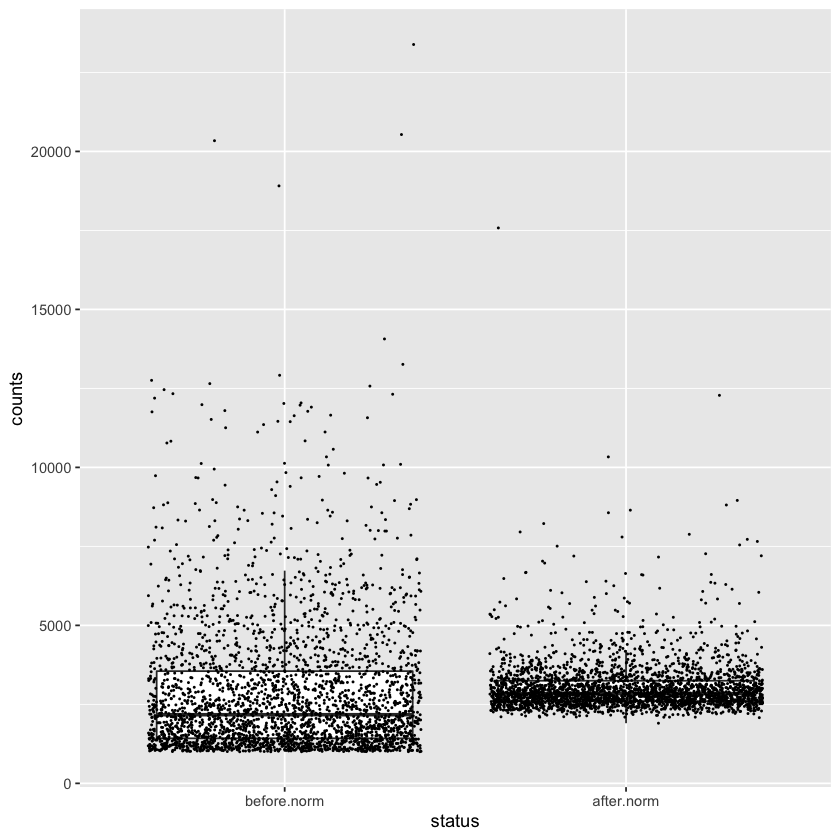

In [22]:
# create SingleCellExperiment object
original_sce <- SingleCellExperiment(
        assays = list(counts = as.matrix(counts_filter))
        ,colData = anno
)
# comupte size factors
original_sce <- computeSumFactors(original_sce)
plot(sizeFactors(original_sce)
     , colSums(counts(original_sce))/1e6, log="xy"
     ,ylab="Library size (millions)", xlab="Size factor"
     ,main = "Size factors (scran normalization)")
# normalize
original_sce <- normalize(original_sce)
if("patientID" %in% colnames(anno)){
        {df <- data.frame(counts = colSums(exprs(original_sce))
                          ,patientID = original_sce$patientID)
        ggplot(data = df
               ,aes(y = counts
                    ,x = patientID)
        ) +
                geom_boxplot(outlier.shape = NA) + 
                geom_jitter(pch = 16, size = 0.5)+
                labs(title = "scran normalized data")
        }
}
# plot 
{
        df <- data.frame(counts = c(colSums(counts_filter)
                                    ,colSums(2^exprs(original_sce)-1)
                                    )
                         ,status = c(rep("before.norm"
                                       ,ncol(counts_filter)
                                       )
                                   ,rep("after.norm"
                                        ,ncol(exprs(original_sce)
                                              )
                                        )
                                   )
                         )
        df$status <- factor(df$status
                          ,levels = c("before.norm"
                                      ,"after.norm"
                                      )
                          ,labels = c("before.norm"
                                      ,"after.norm"
                          )
                          ,ordered = T
                          )
        ggplot(data = df
               ,aes(x = status
                    ,y = counts)
               ) + 
                geom_boxplot(outlier.shape = NA) + 
                geom_jitter(pch = 16, size = 0.5)
}

In [23]:
# export
# counts
write.table(2^exprs(original_sce)-1 # we don't need the log2 transformation for the dwonstream analysis
            ,file = paste0(output.path
                           ,"/counts_filtered_norm.txt")
            ,sep = "\t")



## Split data

In [24]:
options(stringsAsFactors = F)

In [25]:
# Define paths
print(input.path)
main.path <- getwd()
output.path1 <- paste0(main.path
                      ,"/AML328_d0_forComparative")
dir.create(output.path1)
print(output.path1)
output.path2 <- paste0(main.path
                       ,"/AML328_d29_forComparative")
dir.create(output.path2)
print(output.path2)

[1] "/Users/MariaSolovey/Documents/Helmholtz/AG_Scialdone/our_papers/communication/DATASETS/AML_Bernstein_GSE116256/Tutorial_AML_PublicationFigs_revision/AML328_d0_d29_merged"


Warning message in dir.create(output.path1):
“'/Users/MariaSolovey/Documents/Helmholtz/AG_Scialdone/our_papers/communication/DATASETS/AML_Bernstein_GSE116256/Tutorial_AML_PublicationFigs_revision/AML328_d0_forComparative' existiert bereits”


[1] "/Users/MariaSolovey/Documents/Helmholtz/AG_Scialdone/our_papers/communication/DATASETS/AML_Bernstein_GSE116256/Tutorial_AML_PublicationFigs_revision/AML328_d0_forComparative"


Warning message in dir.create(output.path2):
“'/Users/MariaSolovey/Documents/Helmholtz/AG_Scialdone/our_papers/communication/DATASETS/AML_Bernstein_GSE116256/Tutorial_AML_PublicationFigs_revision/AML328_d29_forComparative' existiert bereits”


[1] "/Users/MariaSolovey/Documents/Helmholtz/AG_Scialdone/our_papers/communication/DATASETS/AML_Bernstein_GSE116256/Tutorial_AML_PublicationFigs_revision/AML328_d29_forComparative"


In [26]:
# pathient IDs
patientID1 <- "AML328_d0"
patientID2 <- "AML328_d29"

In [27]:
# read in data
counts <- read.csv(paste0(input.path
                          ,"/counts_filtered_norm.txt")
                   ,sep = "\t"
                   ,check.names = F
                   ,row.names = 1)
dim(counts)
anno <- read.csv(paste0(input.path
                        ,"/anno_merged.txt")
                 ,sep = "\t"
                 ,check.names = F)
dim(anno)

[1] 19685  2904

[1] 2904   31

In [28]:
# check correctness
if(!identical(anno$Cell
              ,colnames(counts))) stop("ERROR: cell IDs are not identical in the annotatin and the count table!")


In [29]:
# split
idx_cond1 <- anno$patientID == patientID1
idx_cond2 <- anno$patientID == patientID2
anno_1 <- anno[idx_cond1,]
dim(anno_1)
counts_1 <- counts[,idx_cond1]
dim(counts_1)

anno_2 <- anno[idx_cond2,]
dim(anno_2)
counts_2 <- counts[,idx_cond2]
dim(counts_2)

[1] 1073   31

[1] 19685  1073

[1] 1831   31

[1] 19685  1831

In [30]:
# export
write.table(counts_1
            ,file = paste0(output.path1
                           ,"/counts_filtered_norm.txt")
            ,sep = "\t")
write.table(anno_1
            ,file = paste0(output.path1
                           ,"/anno_filtered.txt")
            ,sep = "\t")
write.table(counts_2
            ,file = paste0(output.path2
                           ,"/counts_filtered_norm.txt")
            ,sep = "\t")
write.table(anno_2
            ,file = paste0(output.path2
                           ,"/anno_filtered.txt")
            ,sep = "\t")

## Filter genes (x2)
We will filter out genes that have mean mormalized expression (in cells expressing the gene) less or equal 1.

In [31]:
options(stringsAsFactors = F)

Note: the following step takes around 15 min.

[1] "There are 15017 with more than 1 transcript"


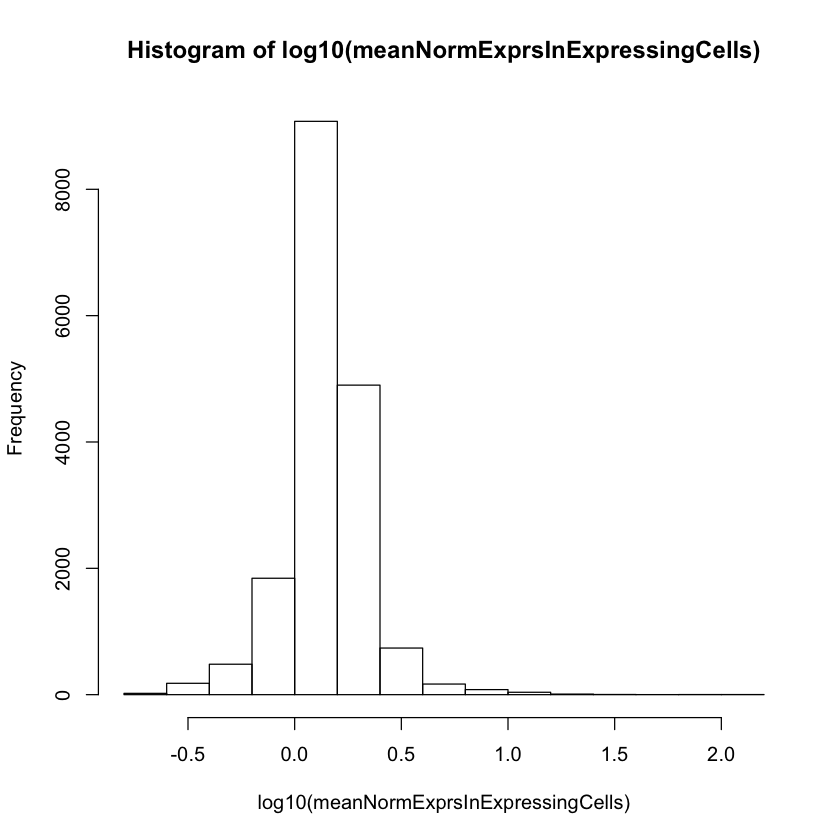

[1] "There are 15322 with more than 1 transcript"


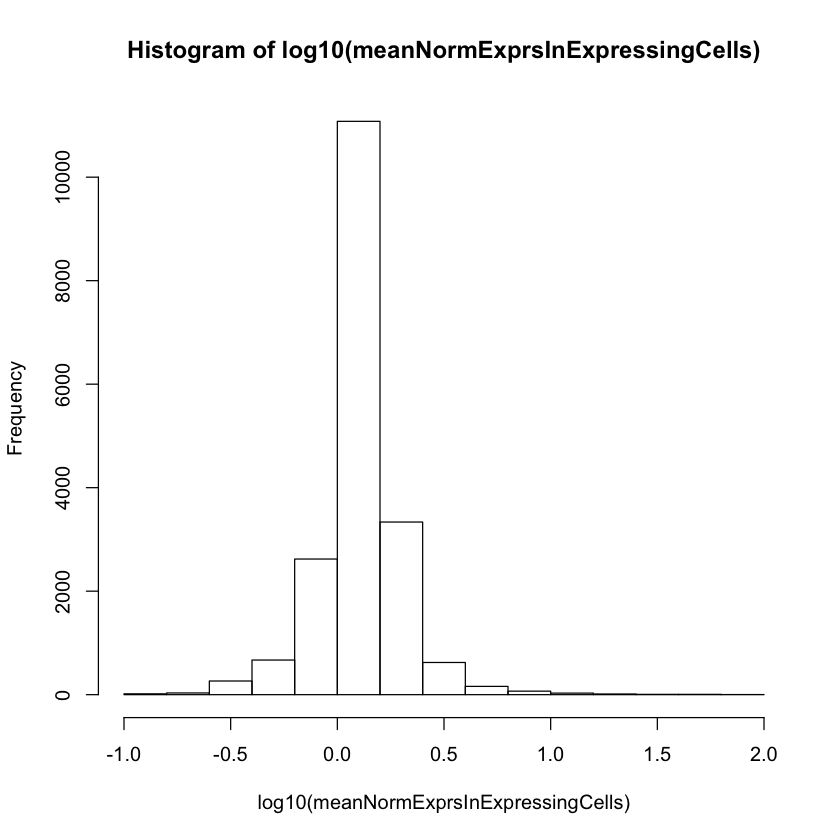

In [32]:
# filter lowly expressed genes
for(condition in c("d0"
                  ,"d29")){
    # Define paths
    if(condition == "d0"){
        input.path  <-  output.path1
        output.path <- output.path1
    } else {
        input.path  <-  output.path2
        output.path <- output.path2
    }
    
    # read in normalized counts
    norm_exprs <- read.csv(paste0(input.path
                              ,"/counts_filtered_norm.txt")
                           ,sep = "\t"
                           ,check.names = F
                           ,row.names = 1
                          )
    
    # calculate mean normalized expression only in cells that express a gene
    isExpressing <- norm_exprs != 0
    # delete all zero genes
    norm_exprs_filtered <- norm_exprs[rowSums(isExpressing) != 0,]
    isExpressing <- isExpressing[rowSums(isExpressing) != 0,]
    
    # calculate means in expressing cells
    meanNormExprsInExpressingCells <- {
        counts <- norm_exprs_filtered
        counts[counts == 0] <- NA
        rowMeans(counts, na.rm=T)
    }
    
    head(meanNormExprsInExpressingCells)
    
    # plot 
    hist(log10(meanNormExprsInExpressingCells))

    print(paste("There are"
          ,sum(meanNormExprsInExpressingCells > 1)
          ,"with more than 1 transcript"))

    # The general low level of expression is most probably due to the UMI method. 
    # For this reason we can use liberal thresholds.

    exprsThreshold <- 1
    filterGenes <- meanNormExprsInExpressingCells > exprsThreshold
    norm_exprs_filtered <- norm_exprs_filtered[filterGenes,]
    dim(norm_exprs)
    dim(norm_exprs_filtered)

    # export
    write.table(norm_exprs_filtered
                ,file = paste0(output.path
                               ,"/counts_filtered_norm.txt")
                ,sep = "\t")

}

In [33]:
# filter genes present only in one condition
counts1 <- read.csv(paste0(output.path1
                           ,"/counts_filtered_norm.txt")
                    ,sep = "\t"
                    ,check.names = F
                    ,row.names = 1
                    )
counts2 <- read.csv(paste0(output.path2
                           ,"/counts_filtered_norm.txt")
                    ,sep = "\t"
                    ,check.names = F
                    ,row.names = 1
                    )

# shared genes
sharedGenes <- intersect(rownames(counts1)
                         ,rownames(counts2)
                         )

#filter 
counts1_filtered <- counts1[rownames(counts1) %in% sharedGenes,]
dim(counts1)
dim(counts1_filtered)
counts2_filtered <- counts2[rownames(counts2) %in% sharedGenes,]
dim(counts2)
dim(counts2_filtered)

# export
write.table(counts1_filtered
            ,file = paste0(output.path1
                           ,"/counts_filtered_norm.txt"
                           )
            ,sep = "\t"
            )
write.table(counts2_filtered
            ,file = paste0(output.path2
                           ,"/counts_filtered_norm.txt"
            )
            ,sep = "\t"
)

[1] 15017  1073

[1] 12801  1073

[1] 15322  1831

[1] 12801  1831

# UMAP of the data

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”



        B       CTL       HSC  HSC-like      Mono Mono-like        NK    Plasma 
       12        22        19       143        79       214        75         7 
     Prog Prog-like         T  cDC-like  earlyEry   lateEry 
        8       281       108        52        44         9 


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


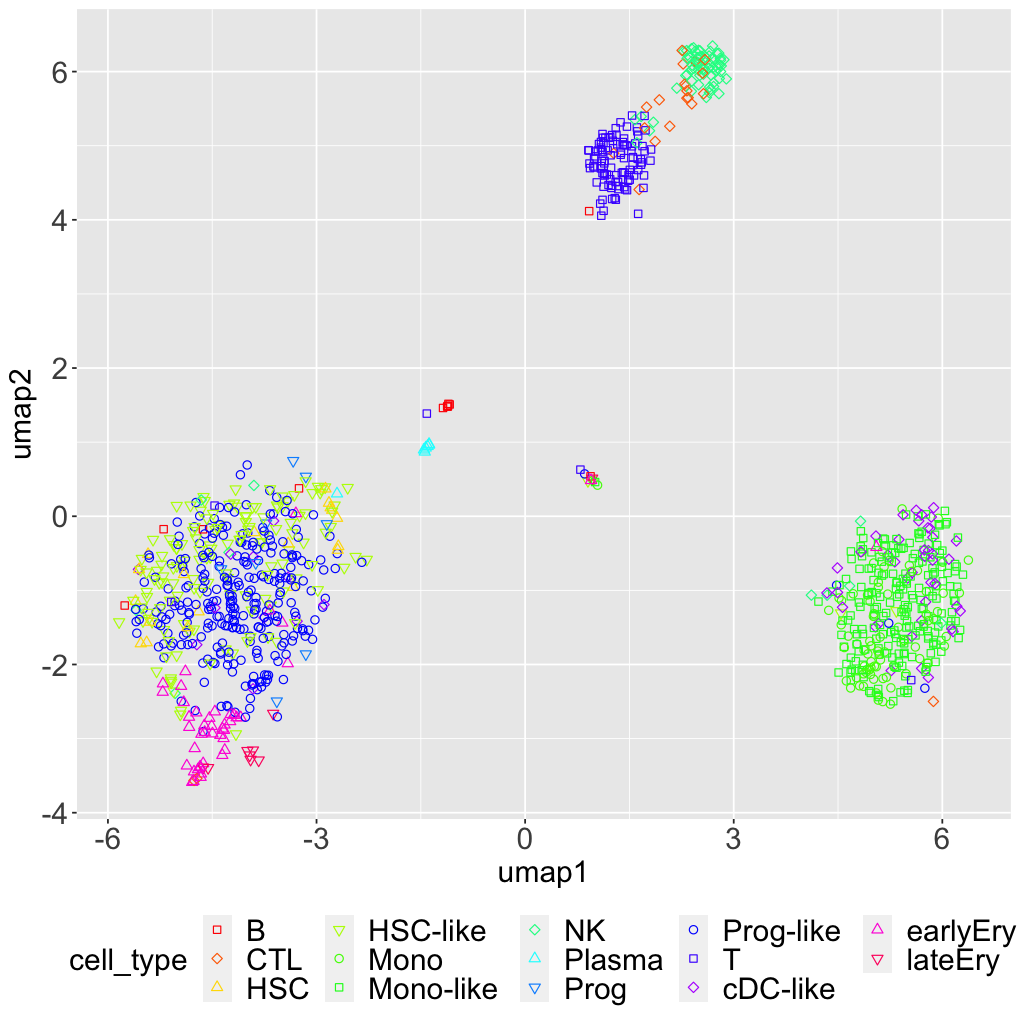


        B       CTL       HSC  HSC-like      Mono Mono-like        NK    Plasma 
       15        34        63       365         6        19       134         5 
     Prog Prog-like         T  cDC-like  earlyEry   lateEry 
       16       721       282        13        82        76 


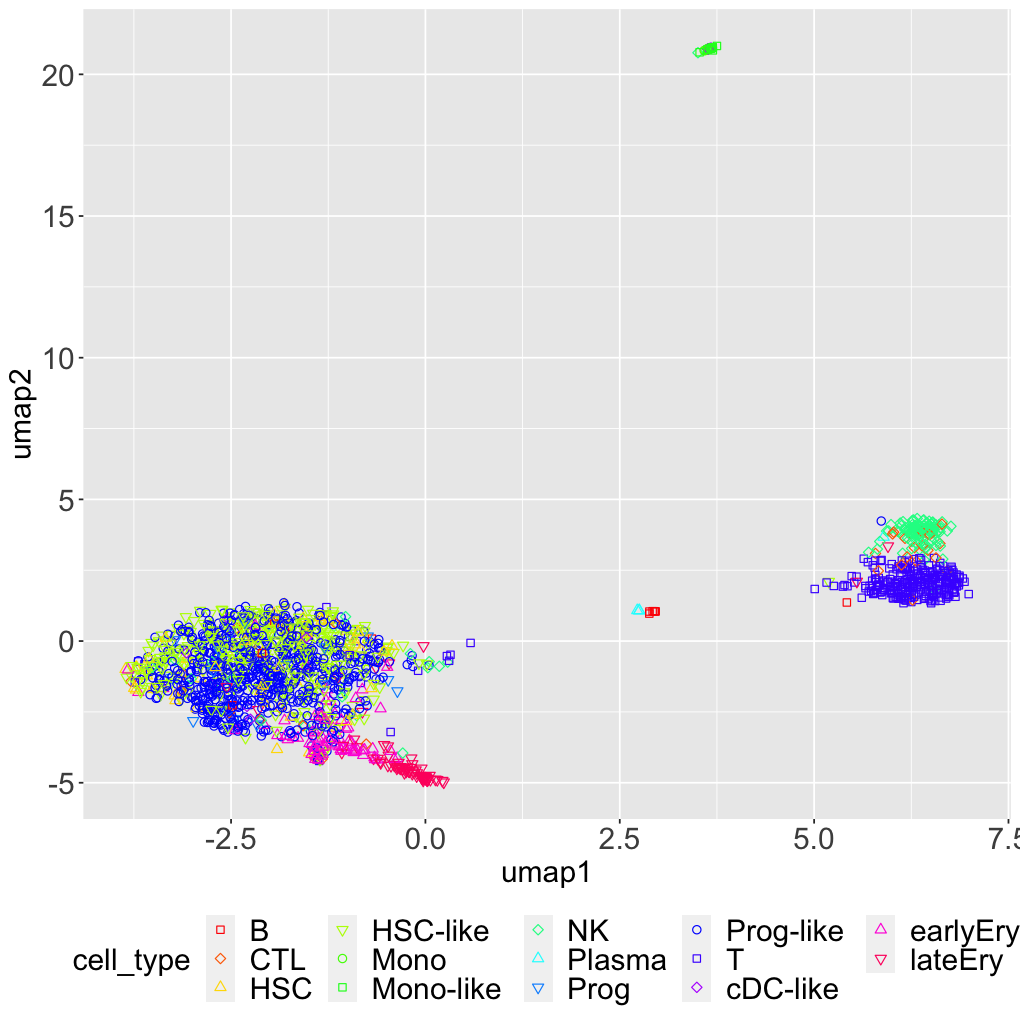

In [34]:
for (cond in c("d0"
              ,"d19")
    ){
    # define variables
    if (cond == "d0"){
        norm_exprs <- counts1_filtered
        anno <- anno_1
    } else {
        norm_exprs <- counts2_filtered
        anno <- anno_2
    }
    # calcualte HVG
    seurat.obj <- CreateSeuratObject(counts = norm_exprs # NOTE: this is already normalized data!
                               )
    # identify HVGs
    seurat.obj <- FindVariableFeatures(seurat.obj, selection.method = "vst", nfeatures = 2000)
    # Identify the 10 most highly variable genes
    top10 <- head(VariableFeatures(seurat.obj), 10)
    top10

    HVG <- seurat.obj@assays$RNA@var.features

    # make dissimilarity matrix
    # Calculate distance matrix
    chosen.exprs <- norm_exprs[HVG,]
    # Calculate distance matrix between cells
    dissimMatrix <- sqrt((1-cor(chosen.exprs, method = "spearman"))/2)

    # calculate UMAP
    fontsize <- 18
    set.seed(100)
    custom.settings <-  umap.defaults
    custom.settings$input <- "dist"
    my.umap <- umap(dissimMatrix
                    ,config = custom.settings
                    )

    # prepare dataframe for plotting
    dfForUmap <- data.frame(x=my.umap$layout[,1]
                            ,y=my.umap$layout[,2]
                            ,cell_type=anno$cell_type
    )
    dfForUmap$cell_type <- as.factor(as.character(dfForUmap$cell_type))
    cell_type.col <- structure(rainbow(length(levels(dfForUmap$cell_type))))
    names(cell_type.col) <- levels(dfForUmap$cell_type)

    cell_type.shape <- c(1:length(cell_type.col)) %% 5 +21
    names(cell_type.shape) <- names(cell_type.col)

    # plot UMAP
    umap.clusters <- ggplot(dfForUmap
                            , aes(x=x
                                  ,y=y
                                  ,color=cell_type
                                  ,shape = cell_type
                            )
    )+
            geom_point(size=2) +
            scale_color_manual(name = "cell_type"
                               ,labels = names(cell_type.col)
                               ,values = cell_type.col) +
            scale_shape_manual(name = "cell_type"
                               ,labels = names(cell_type.shape)
                               ,values = cell_type.shape) +
            ylab("umap2") +
            xlab("umap1") +
            #ggtitle("umap of ligand-receptor pairs") +
            theme(legend.position="bottom"
                  ,axis.title = element_text(size = fontsize)
                  ,axis.text = element_text(size = fontsize)
                  ,legend.text = element_text(size = fontsize)
                  ,legend.title = element_text(size = fontsize)
            ) +
            guides(fill=guide_legend(nrow=2
                                     ,direction = "horizontal"
                                     ,title.position = "top"
                                     ,label.position= "bottom"
                                     ,byrow=TRUE
            )
            )
    options(repr.plot.width = 8.5, repr.plot.height = 8.5)
    print(umap.clusters)
    
    print(table(dfForUmap$cell_type))
}
